<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/daging_sapi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [2]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [3]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fb9d4221e80>)

In [4]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [5]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [6]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.daging_sapi_kualitas_1.values
date = dataset.index

## Train test val split

In [7]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


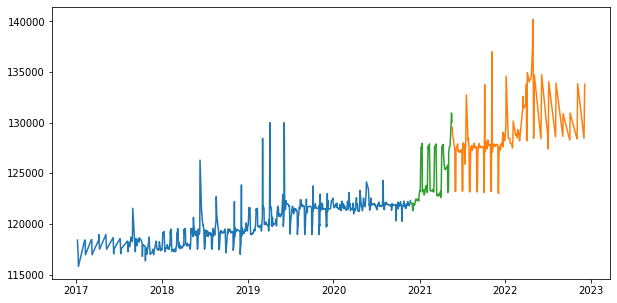

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [9]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [10]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_sapi1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 18s 46ms/step - loss: 0.1700 - mae: 0.4101 - mape: 96.5240 - val_loss: 0.2155 - val_mae: 0.4076 - val_mape: 81.1836
Epoch 2/30
44/44 [==============================] - 1s 21ms/step - loss: 0.1037 - mae: 0.3200 - mape: 75.2260 - val_loss: 0.1626 - val_mae: 0.3367 - val_mape: 61.4617
Epoch 3/30
44/44 [==============================] - 1s 21ms/step - loss: 0.0673 - mae: 0.2569 - mape: 60.2584 - val_loss: 0.1295 - val_mae: 0.2885 - val_mape: 49.9423
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0446 - mae: 0.2086 - mape: 48.8545 - val_loss: 0.1071 - val_mae: 0.2650 - val_mape: 48.5444
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0297 - mae: 0.1691 - mape: 39.5090 - val_loss: 0.0913 - val_mae: 0.2487 - val_mape: 48.9412
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0197 - mae: 0.1364 - mape: 31.7448 - val_loss: 0.0801 - val_mae: 0.2353 - val_mape: 49.27

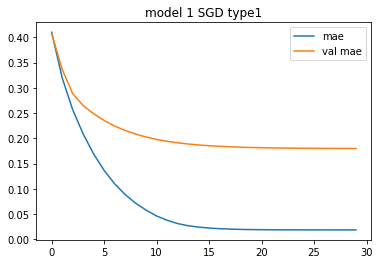

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2806.6426 2.1522593 3638.6615671150294


,date,actual,prediction
0,2021-05-20,129550,125869.406250
1,2021-05-21,128900,125866.843750
2,2021-05-24,128500,125878.617188
3,2021-05-25,128350,125884.109375
4,2021-05-27,127950,125898.867188
...,...,...,...
229,2022-11-02,128700,126321.625000
230,2022-11-03,130950,126343.109375
231,2022-11-04,133850,126312.226562
232,2022-12-01,128450,126332.742188


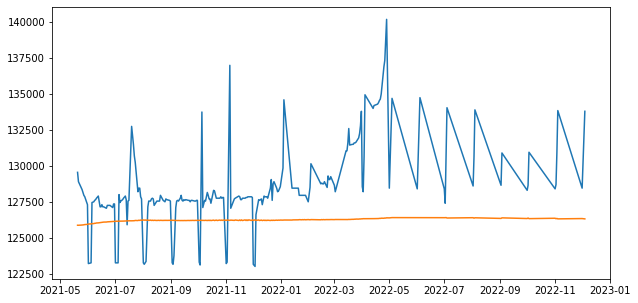

In [ ]:
prediction = forecast_predict(model, test_sapi1_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_sapi1 = pd.DataFrame()
data_new_sapi1['date'] = y_test
data_new_sapi1['actual'] = x_test
data_new_sapi1['prediction'] = data_result
data_new_sapi1.to_csv('sapi1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_sapi1.date, data_new_sapi1.actual)
plt.plot(data_new_sapi1.date, data_new_sapi1.prediction)
data_new_sapi1

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0128 - mae: 0.0859 - mape: 37.7995 - val_loss: 0.0558 - val_mae: 0.1921 - val_mape: 50.3517
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0107 - mae: 0.0759 - mape: 32.3530 - val_loss: 0.0552 - val_mae: 0.1906 - val_mape: 50.4113
Epoch 3/30
718/718 [==============================] - 7s 10ms/step - loss: 0.0096 - mae: 0.0692 - mape: 29.7598 - val_loss: 0.0547 - val_mae: 0.1895 - val_mape: 50.3856
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0091 - mae: 0.0647 - mape: 28.1629 - val_loss: 0.0554 - val_mae: 0.1920 - val_mape: 50.3892
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0083 - mae: 0.0606 - mape: 25.9737 - val_loss: 0.0543 - val_mae: 0.1886 - val_mape: 50.4303
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0083 - mae: 0.0606 - mape: 26.0734 - val_loss: 0.0549 - val_mae: 0.1905 - val_mape:

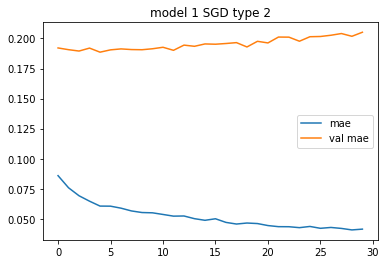

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
2801.9734 2.1518235 3579.5967650002144


,date,actual,prediction
0,2021-05-20,129550,125869.406250
1,2021-05-21,128900,125866.843750
2,2021-05-24,128500,125878.617188
3,2021-05-25,128350,125884.109375
4,2021-05-27,127950,125898.867188
...,...,...,...
229,2022-11-02,128700,126321.625000
230,2022-11-03,130950,126343.109375
231,2022-11-04,133850,126312.226562
232,2022-12-01,128450,126332.742188


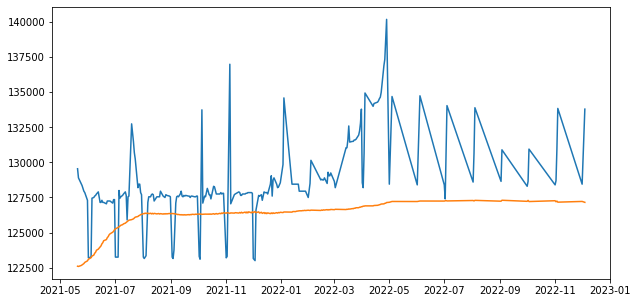

In [ ]:
win_size1 = 60
test_sapi1_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_sapi1_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_sapi1_1 = pd.DataFrame()
data_new_sapi1_1['actual'] = x_test
data_new_sapi1_1['prediction'] = data_result_1
data_new_sapi1_1.to_csv('sapi1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi1_1.actual)
plt.plot(y_test, data_new_sapi1_1.prediction)
data_new_sapi1

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0041 - mae: 0.0316 - mape: 8.2991 - val_loss: 0.0602 - val_mae: 0.2059 - val_mape: 49.7462
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0041 - mae: 0.0316 - mape: 8.3417 - val_loss: 0.0599 - val_mae: 0.2055 - val_mape: 49.7580
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0041 - mae: 0.0316 - mape: 8.2932 - val_loss: 0.0599 - val_mae: 0.2055 - val_mape: 49.7580
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0041 - mae: 0.0315 - mape: 8.3078 - val_loss: 0.0599 - val_mae: 0.2055 - val_mape: 49.7578
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0041 - mae: 0.0316 - mape: 8.3356 - val_loss: 0.0601 - val_mae: 0.2059 - val_mape: 49.7473
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0041 - mae: 0.0316 - mape: 8.3264 - val_loss: 0.0600 - val_mae: 0.2055 - val_mape: 49.7560
Epoc

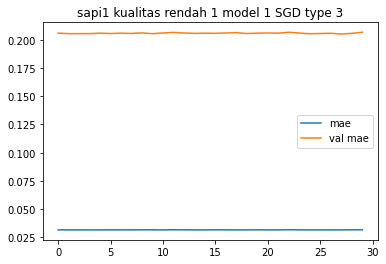

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('sapi1 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
2696.3496 2.0701208 3501.3297473959806


,actual,prediction
0,129550,122724.382812
1,128900,122706.359375
2,128500,122776.273438
3,128350,122814.703125
4,127950,122911.414062
...,...,...
229,128700,127296.664062
230,130950,127348.195312
231,133850,127270.250000
232,128450,127321.187500


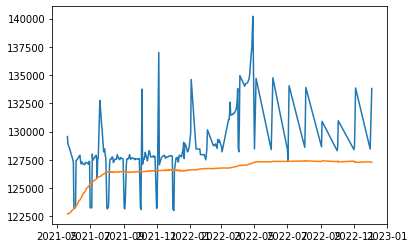

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_sapi1_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_sapi1_2 = pd.DataFrame()
# data_new_sapi11['date'] = date_test
data_new_sapi1_2['actual'] = x_test
data_new_sapi1_2['prediction'] = data_result_2
data_new_sapi1_2.to_csv('sapi1_model1_sgd_type3')

plt.plot(y_test, data_new_sapi1_2.actual)
plt.plot(y_test, data_new_sapi1_2.prediction)
data_new_sapi1_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 4s 37ms/step - loss: 0.1322 - mae: 0.3604 - mape: 84.7671 - val_loss: 0.1764 - val_mae: 0.3574 - val_mape: 67.2784
Epoch 2/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0458 - mae: 0.2037 - mape: 47.6967 - val_loss: 0.0804 - val_mae: 0.2367 - val_mape: 49.0967
Epoch 3/30
44/44 [==============================] - 1s 20ms/step - loss: 0.0023 - mae: 0.0336 - mape: 7.7925 - val_loss: 0.0565 - val_mae: 0.1969 - val_mape: 49.9274
Epoch 4/30
44/44 [==============================] - 1s 19ms/step - loss: 9.8890e-04 - mae: 0.0189 - mape: 4.3854 - val_loss: 0.0583 - val_mae: 0.2011 - val_mape: 49.8389
Epoch 5/30
44/44 [==============================] - 1s 19ms/step - loss: 0.0010 - mae: 0.0189 - mape: 4.3613 - val_loss: 0.0576 - val_mae: 0.1995 - val_mape: 49.8741
Epoch 6/30
44/44 [==============================] - 1s 20ms/step - loss: 9.9449e-04 - mae: 0.0183 - mape: 4.2221 - val_loss: 0.0581 - val_mae: 0.2005 - val_mape: 49

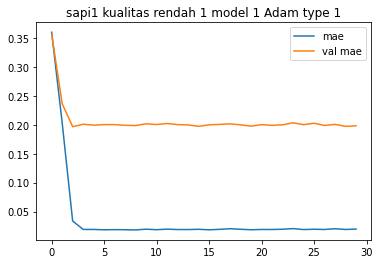

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('sapi1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 7ms/step
2376.0364 1.8238696 3178.7050822622723


,actual,prediction
0,129550,123910.531250
1,128900,123933.406250
2,128500,123948.148438
3,128350,123989.460938
4,127950,124029.718750
...,...,...
229,128700,128389.031250
230,130950,128372.414062
231,133850,128376.562500
232,128450,128358.804688


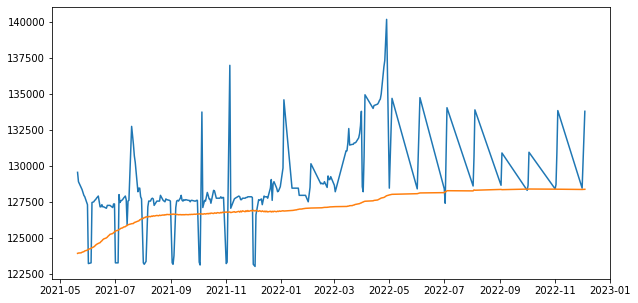

In [ ]:
prediction_a = forecast_predict(model_a, test_sapi1_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_sapi1_a = pd.DataFrame()
# data_new_sapi11['date'] = date_test
data_new_sapi1_a['actual'] = x_test
data_new_sapi1_a['prediction'] = data_result_a
data_new_sapi1_a.to_csv('sapi1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_sapi1_a.actual)
plt.plot(y_test, data_new_sapi1_a.prediction)
data_new_sapi1_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0056 - mae: 0.0464 - mape: 18.0753 - val_loss: 0.0593 - val_mae: 0.2036 - val_mape: 49.7601
Epoch 2/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0439 - mape: 17.2355 - val_loss: 0.0634 - val_mae: 0.2119 - val_mape: 49.5423
Epoch 3/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0053 - mae: 0.0425 - mape: 16.3172 - val_loss: 0.0610 - val_mae: 0.2076 - val_mape: 49.5908
Epoch 4/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0436 - mape: 16.7972 - val_loss: 0.0627 - val_mae: 0.2110 - val_mape: 49.4830
Epoch 5/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0052 - mae: 0.0428 - mape: 16.0687 - val_loss: 0.0612 - val_mae: 0.2083 - val_mape: 49.5531
Epoch 6/30
718/718 [==============================] - 6s 8ms/step - loss: 0.0054 - mae: 0.0429 - mape: 16.3142 - val_loss: 0.0614 - val_mae: 0.2089 - val_mape: 

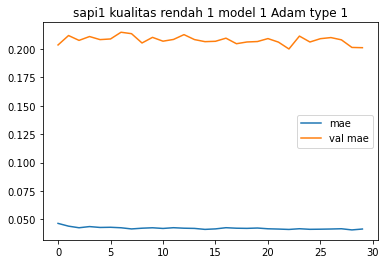

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('sapi1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
2362.34 1.814493 3199.528871568438


,actual,prediction
0,129550,122721.664062
1,128900,122636.609375
2,128500,123005.304688
3,128350,122763.976562
4,127950,123153.195312
...,...,...
229,128700,128770.476562
230,130950,128688.695312
231,133850,128751.437500
232,128450,128791.828125


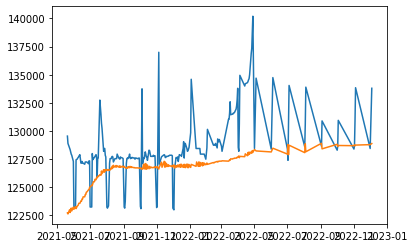

In [ ]:
prediction_a1 = forecast_predict(model_a, test_sapi1_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_sapi1_a1 = pd.DataFrame()
data_new_sapi1_a1['actual'] = x_test
data_new_sapi1_a1['prediction'] = data_result_a1
data_new_sapi1_a1.to_csv('sapi1_model1_adam_type2.csv')

plt.plot(y_test, data_new_sapi1_a1.actual)
plt.plot(y_test, data_new_sapi1_a1.prediction)
data_new_sapi1_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 1s 16ms/step - loss: 0.0041 - mae: 0.0319 - mape: 8.3736 - val_loss: 0.0576 - val_mae: 0.2034 - val_mape: 49.0211
Epoch 2/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0040 - mae: 0.0315 - mape: 8.2855 - val_loss: 0.0592 - val_mae: 0.2064 - val_mape: 48.9313
Epoch 3/30
84/84 [==============================] - 1s 15ms/step - loss: 0.0041 - mae: 0.0326 - mape: 8.5249 - val_loss: 0.0579 - val_mae: 0.2040 - val_mape: 48.9529
Epoch 4/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0040 - mae: 0.0313 - mape: 8.1487 - val_loss: 0.0570 - val_mae: 0.2021 - val_mape: 48.9786
Epoch 5/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0041 - mae: 0.0329 - mape: 8.6128 - val_loss: 0.0581 - val_mae: 0.2042 - val_mape: 48.9149
Epoch 6/30
84/84 [==============================] - 1s 14ms/step - loss: 0.0040 - mae: 0.0319 - mape: 8.3349 - val_loss: 0.0577 - val_mae: 0.2033 - val_mape: 48.8968
Epoc

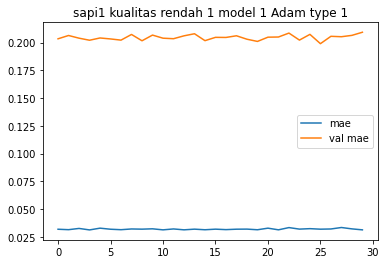

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('sapi1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 6ms/step
3216.1243 2.4699574 4003.380946150391


,actual,prediction
0,129550,122707.351562
1,128900,122597.226562
2,128500,123054.570312
3,128350,122706.906250
4,127950,123164.539062
...,...,...
229,128700,126207.562500
230,130950,126003.976562
231,133850,126264.148438
232,128450,126179.695312


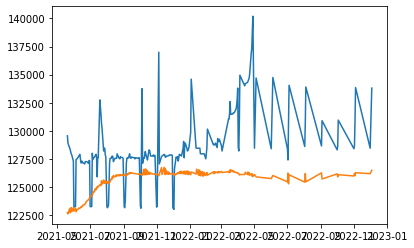

In [ ]:
prediction_a2 = forecast_predict(model_a, test_sapi1_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_sapi1_a2 = pd.DataFrame()
# data_new_sapi11['date'] = date_test
data_new_sapi1_a2['actual'] = x_test
data_new_sapi1_a2['prediction'] = data_result_a2
data_new_sapi1_a2.to_csv('sapi1_model1_adam_type3.csv')

plt.plot(y_test, data_new_sapi1_a2.actual)
plt.plot(y_test, data_new_sapi1_a2.prediction)
data_new_sapi1_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 42ms/step - loss: 0.0880 - mae: 0.2725 - mape: 64.1166 - val_loss: 0.0572 - val_mae: 0.1990 - val_mape: 49.8170
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0019 - mae: 0.0316 - mape: 7.4665 - val_loss: 0.0580 - val_mae: 0.2008 - val_mape: 49.8859
Epoch 3/15
44/44 [==============================] - 1s 23ms/step - loss: 0.0010 - mae: 0.0204 - mape: 4.7068 - val_loss: 0.0593 - val_mae: 0.2036 - val_mape: 49.8401
Epoch 4/15
44/44 [==============================] - 1s 31ms/step - loss: 0.0011 - mae: 0.0197 - mape: 4.5227 - val_loss: 0.0582 - val_mae: 0.2012 - val_mape: 49.8885
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0010 - mae: 0.0189 - mape: 4.3511 - val_loss: 0.0587 - val_mae: 0.2021 - val_mape: 49.8709
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0010 - mae: 0.0195 - mape: 4.5234 - val_loss: 0.0592 - val_mae: 0.2032 - val_mape: 49.8498
Epo

17/17 [==============================] - 0s 7ms/step - loss: 0.0288 - mae: 0.1244 - mape: 24.7128


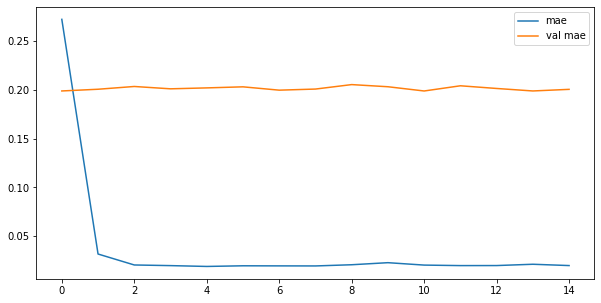

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_sapi1_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_sapi11 = pd.DataFrame()
data_new_sapi11['actual'] = x_test
data_new_sapi11['prediction'] = data_result1
data_new_sapi11.to_csv('sapi1_model2_adam_type1.csv')

data_new_sapi11

131/131 [==============================] - 2s 8ms/step
2323.7017 1.7843959 3127.4553553967803


,actual,prediction
0,129550,123585.562500
1,128900,123585.921875
2,128500,123601.187500
3,128350,123631.078125
4,127950,123672.812500
...,...,...
229,128700,128727.617188
230,130950,128729.570312
231,133850,128708.539062
232,128450,128704.265625


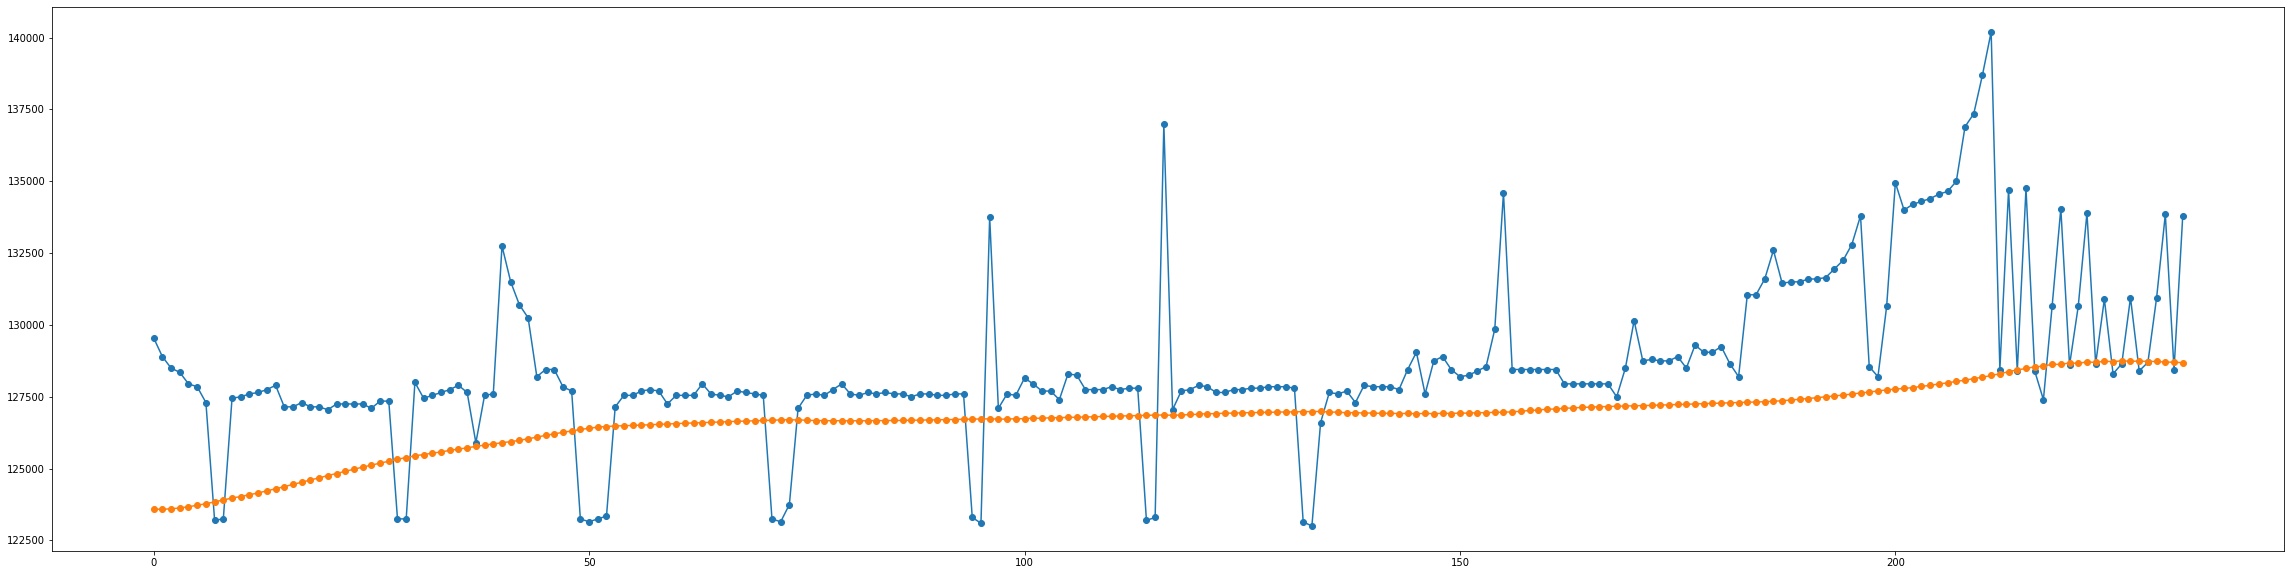

In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_sapi11['actual'], '-o')
plt.plot(range(len(x_test)), data_new_sapi11['prediction'], '-o')

#### Type 2

In [12]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 24s 10ms/step - loss: 0.0071 - mae: 0.0523 - mape: 20.4885 - val_loss: 0.0604 - val_mae: 0.2071 - val_mape: 50.4493
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0057 - mae: 0.0460 - mape: 17.4777 - val_loss: 0.0616 - val_mae: 0.2100 - val_mape: 50.5659
Epoch 3/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0056 - mae: 0.0452 - mape: 16.9280 - val_loss: 0.0611 - val_mae: 0.2095 - val_mape: 50.5678
Epoch 4/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0056 - mae: 0.0451 - mape: 17.1380 - val_loss: 0.0639 - val_mae: 0.2150 - val_mape: 50.4920
Epoch 5/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0055 - mae: 0.0446 - mape: 16.9841 - val_loss: 0.0572 - val_mae: 0.2022 - val_mape: 50.6457
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0054 - mae: 0.0446 - mape: 16.5493 - val_loss: 0.0606 - val_mae: 0.2095 - val_map

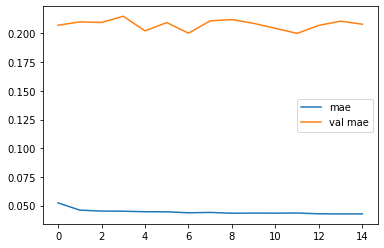

In [13]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 6ms/step
2047.7775 1.5739111 2888.647953628133


,actual,prediction
0,129550,122944.632812
1,128900,122846.234375
2,128500,123047.539062
3,128350,122950.242188
4,127950,123164.265625
...,...,...
229,128700,130085.914062
230,130950,129455.937500
231,133850,130082.875000
232,128450,129413.476562


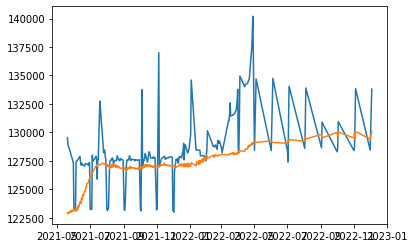

In [14]:
prediction1_1 = forecast_predict(model1, test_sapi1_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_sapi11_1 = pd.DataFrame()
data_new_sapi11_1['actual'] = x_test
data_new_sapi11_1['prediction'] = data_result1_1
data_new_sapi11_1.to_csv('sapi1_model2_adam_type2.csv')

plt.plot(y_test, data_new_sapi11_1.actual)
plt.plot(y_test, data_new_sapi11_1.prediction)
data_new_sapi11_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 47ms/step - loss: 0.0498 - mae: 0.1655 - mape: 40.7966 - val_loss: 0.0589 - val_mae: 0.2043 - val_mape: 50.6083
Epoch 2/15
84/84 [==============================] - 2s 18ms/step - loss: 0.0041 - mae: 0.0335 - mape: 8.8108 - val_loss: 0.0601 - val_mae: 0.2070 - val_mape: 50.5525
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0346 - mape: 9.0853 - val_loss: 0.0624 - val_mae: 0.2114 - val_mape: 50.4450
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0348 - mape: 9.1451 - val_loss: 0.0585 - val_mae: 0.2035 - val_mape: 50.6267
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0354 - mape: 9.2781 - val_loss: 0.0591 - val_mae: 0.2049 - val_mape: 50.6275
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0042 - mae: 0.0359 - mape: 9.3568 - val_loss: 0.0645 - val_mae: 0.2152 - val_mape: 50.3812
Ep

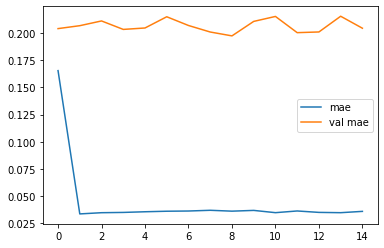

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 6ms/step
2324.1545 1.7860843 3083.1080097849313


,actual,prediction
0,129550,123185.820312
1,128900,123208.937500
2,128500,123209.210938
3,128350,123252.000000
4,127950,123282.695312
...,...,...
229,128700,129229.500000
230,130950,129087.867188
231,133850,129176.210938
232,128450,129035.320312


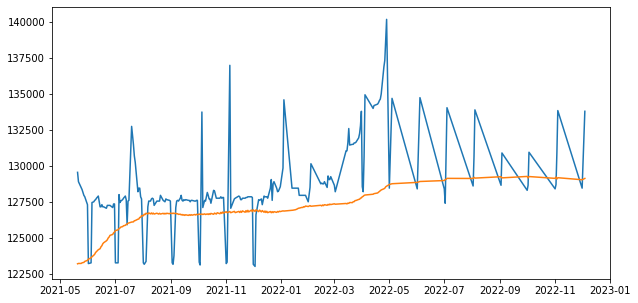

In [ ]:
prediction1_2 = forecast_predict(model1, test_sapi1_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_sapi11_2 = pd.DataFrame()
data_new_sapi11_2['actual'] = x_test
data_new_sapi11_2['prediction'] = data_result1_2
data_new_sapi11_2.to_csv('sapi1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi11_2.actual)
plt.plot(y_test, data_new_sapi11_2.prediction)

data_new_sapi11_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 5s 41ms/step - loss: 0.1615 - mae: 0.4000 - mape: 94.1386 - val_loss: 0.2179 - val_mae: 0.4106 - val_mape: 82.0508
Epoch 2/15
44/44 [==============================] - 1s 22ms/step - loss: 0.1074 - mae: 0.3256 - mape: 76.5287 - val_loss: 0.1683 - val_mae: 0.3450 - val_mape: 63.7079
Epoch 3/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0715 - mae: 0.2651 - mape: 62.1941 - val_loss: 0.1345 - val_mae: 0.2954 - val_mape: 51.2566
Epoch 4/15
44/44 [==============================] - 1s 21ms/step - loss: 0.0478 - mae: 0.2161 - mape: 50.6339 - val_loss: 0.1108 - val_mae: 0.2686 - val_mape: 48.4913
Epoch 5/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0319 - mae: 0.1758 - mape: 41.1063 - val_loss: 0.0943 - val_mae: 0.2521 - val_mape: 48.8942
Epoch 6/15
44/44 [==============================] - 1s 22ms/step - loss: 0.0214 - mae: 0.1425 - mape: 33.2004 - val_loss: 0.0825 - val_mae: 0.2384 - val_mape: 49.227

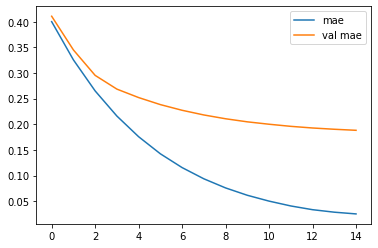

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 2s 8ms/step
3213.9 2.4664793 3981.2153923142614


,actual,prediction
0,129550,125348.445312
1,128900,125349.328125
2,128500,125368.562500
3,128350,125376.984375
4,127950,125399.078125
...,...,...
229,128700,125800.875000
230,130950,125780.390625
231,133850,125791.265625
232,128450,125778.156250


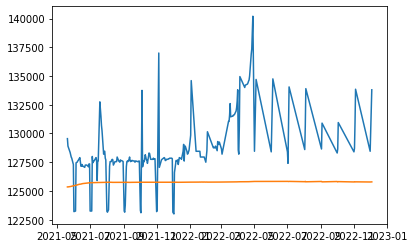

In [ ]:
prediction1_a = forecast_predict(model1_a, test_sapi1_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_sapi11_a = pd.DataFrame()
data_new_sapi11_a['actual'] = x_test
data_new_sapi11_a['prediction'] = data_result1_a
data_new_sapi11_a.to_csv('sapi1_model2_sgd_type1.csv')


plt.plot(y_test, data_new_sapi11_a.actual)
plt.plot(y_test, data_new_sapi11_a.prediction)

data_new_sapi11_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 7s 10ms/step - loss: 0.0113 - mae: 0.0791 - mape: 34.2737 - val_loss: 0.0553 - val_mae: 0.1906 - val_mape: 50.4159
Epoch 2/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0106 - mae: 0.0761 - mape: 32.5529 - val_loss: 0.0549 - val_mae: 0.1896 - val_mape: 50.4442
Epoch 3/15
718/718 [==============================] - 9s 13ms/step - loss: 0.0104 - mae: 0.0738 - mape: 31.8059 - val_loss: 0.0549 - val_mae: 0.1894 - val_mape: 50.4453
Epoch 4/15
718/718 [==============================] - 8s 12ms/step - loss: 0.0102 - mae: 0.0726 - mape: 31.3529 - val_loss: 0.0549 - val_mae: 0.1896 - val_mape: 50.4289
Epoch 5/15
718/718 [==============================] - 8s 11ms/step - loss: 0.0099 - mae: 0.0710 - mape: 30.7110 - val_loss: 0.0551 - val_mae: 0.1902 - val_mape: 50.4131
Epoch 6/15
718/718 [==============================] - 6s 9ms/step - loss: 0.0100 - mae: 0.0713 - mape: 30.6297 - val_loss: 0.0553 - val_mae: 0.1909 - val_ma

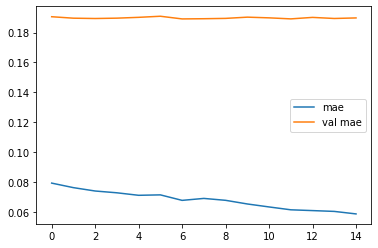

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
3012.1904 2.3112347 3795.180232874323


,actual,prediction
0,129550,124628.585938
1,128900,124633.226562
2,128500,124682.304688
3,128350,124708.515625
4,127950,124768.726562
...,...,...
229,128700,126154.226562
230,130950,126135.867188
231,133850,126137.484375
232,128450,126125.898438


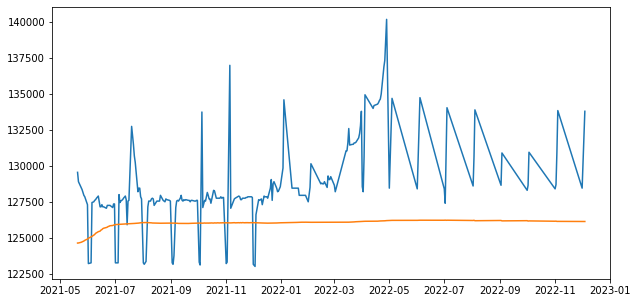

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_sapi1_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_sapi11_a1 = pd.DataFrame()
data_new_sapi11_a1['actual'] = x_test
data_new_sapi11_a1['prediction'] = data_result1_a1
data_new_sapi11_a1.to_csv('sapi1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi11_a1.actual)
plt.plot(y_test, data_new_sapi11_a1.prediction)
data_new_sapi11_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 2s 20ms/step - loss: 0.0043 - mae: 0.0348 - mape: 9.3913 - val_loss: 0.0552 - val_mae: 0.1916 - val_mape: 50.3244
Epoch 2/15
84/84 [==============================] - 2s 19ms/step - loss: 0.0043 - mae: 0.0347 - mape: 9.3854 - val_loss: 0.0552 - val_mae: 0.1915 - val_mape: 50.3250
Epoch 3/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0354 - mape: 9.4435 - val_loss: 0.0555 - val_mae: 0.1924 - val_mape: 50.3029
Epoch 4/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0348 - mape: 9.3656 - val_loss: 0.0554 - val_mae: 0.1920 - val_mape: 50.3144
Epoch 5/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0349 - mape: 9.3687 - val_loss: 0.0555 - val_mae: 0.1924 - val_mape: 50.3031
Epoch 6/15
84/84 [==============================] - 1s 16ms/step - loss: 0.0043 - mae: 0.0349 - mape: 9.3633 - val_loss: 0.0555 - val_mae: 0.1925 - val_mape: 50.3009
Epoc

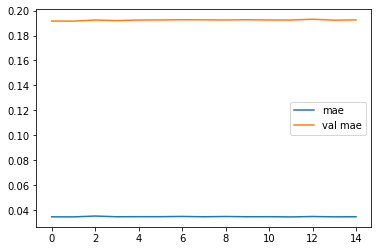

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 5ms/step
3000.55 2.3024695 3778.2947211672094


,actual,prediction
0,129550,124460.296875
1,128900,124464.968750
2,128500,124514.406250
3,128350,124540.710938
4,127950,124601.046875
...,...,...
229,128700,126214.367188
230,130950,126195.968750
231,133850,126197.718750
232,128450,126186.109375


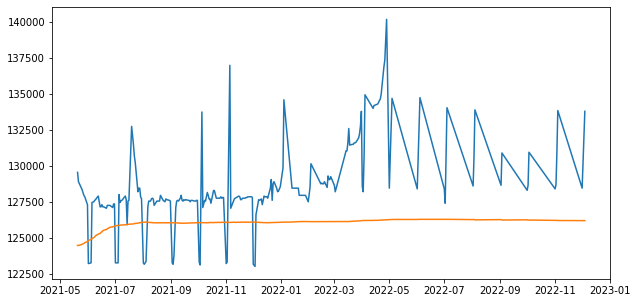

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_sapi1_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_sapi11_a2 = pd.DataFrame()
data_new_sapi11_a2['actual'] = x_test
data_new_sapi11_a2['prediction'] = data_result1_a2
data_new_sapi11_a2.to_csv('sapi1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi11_a2.actual)
plt.plot(y_test, data_new_sapi11_a2.prediction)

data_new_sapi11_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 4s 35ms/step - loss: 0.1669 - mae: 0.4069 - mape: 95.7523 - val_loss: 0.2274 - val_mae: 0.4219 - val_mape: 85.1877
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.1190 - mae: 0.3433 - mape: 80.7439 - val_loss: 0.1812 - val_mae: 0.3632 - val_mape: 68.7919
Epoch 3/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0844 - mae: 0.2885 - mape: 67.7547 - val_loss: 0.1485 - val_mae: 0.3162 - val_mape: 56.2808
Epoch 4/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0604 - mae: 0.2433 - mape: 57.0427 - val_loss: 0.1244 - val_mae: 0.2814 - val_mape: 48.6615
Epoch 5/50
44/44 [==============================] - 1s 14ms/step - loss: 0.0432 - mae: 0.2053 - mape: 48.0713 - val_loss: 0.1067 - val_mae: 0.2647 - val_mape: 48.6528
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0310 - mae: 0.1731 - mape: 40.4620 - val_loss: 0.0935 - val_mae: 0.2513 - val_mape: 48.988

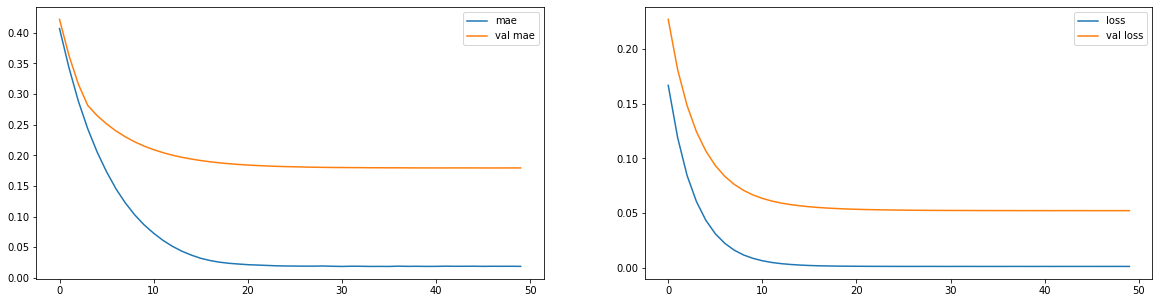

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 1s 6ms/step
2831.14 2.1709118 3670.596681739905


,actual,prediction
0,129550,125897.023438
1,128900,125903.531250
2,128500,125897.679688
3,128350,125900.460938
4,127950,125903.578125
...,...,...
229,128700,126264.609375
230,130950,126264.195312
231,133850,126263.515625
232,128450,126261.828125


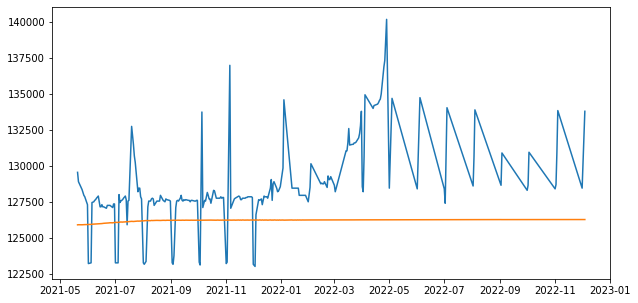

In [ ]:
prediction2 = forecast_predict(model2, test_sapi1_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_sapi12 = pd.DataFrame()
data_new_sapi12['actual'] = x_test
data_new_sapi12['prediction'] = data_result2
data_new_sapi12.to_csv('sapi1_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_sapi12.actual)
plt.plot(y_test, data_new_sapi12.prediction)
data_new_sapi12

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0133 - mae: 0.0888 - mape: 39.3596 - val_loss: 0.0567 - val_mae: 0.1944 - val_mape: 50.4052
Epoch 2/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0115 - mae: 0.0821 - mape: 35.0857 - val_loss: 0.0566 - val_mae: 0.1943 - val_mape: 50.4016
Epoch 3/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0114 - mae: 0.0824 - mape: 35.1218 - val_loss: 0.0565 - val_mae: 0.1940 - val_mape: 50.4015
Epoch 4/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0112 - mae: 0.0805 - mape: 34.2912 - val_loss: 0.0563 - val_mae: 0.1934 - val_mape: 50.4093
Epoch 5/50
718/718 [==============================] - 5s 8ms/step - loss: 0.0108 - mae: 0.0775 - mape: 33.2463 - val_loss: 0.0559 - val_mae: 0.1925 - val_mape: 50.4183
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0107 - mae: 0.0773 - mape: 33.2098 - val_loss: 0.0560 - val_mae: 0.1928 - val_mape: 

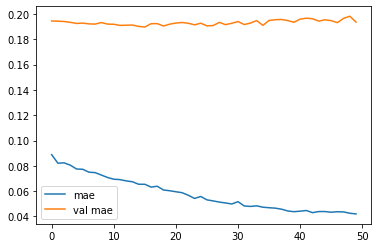

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_sapi1_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_sapi12_1 = pd.DataFrame()
data_new_sapi12_1['actual'] = x_test
data_new_sapi12_1['prediction'] = data_result2_1
data_new_sapi12_1.to_csv('sapi1_model3_sgd_type2.csv')

data_new_sapi12

199/199 [==============================] - 1s 3ms/step
3332.8547 2.5621202 4044.573525107437


,actual,prediction
0,129550,125897.023438
1,128900,125903.531250
2,128500,125897.679688
3,128350,125900.460938
4,127950,125903.578125
...,...,...
229,128700,126264.609375
230,130950,126264.195312
231,133850,126263.515625
232,128450,126261.828125


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0043 - mae: 0.0343 - mape: 9.2374 - val_loss: 0.0568 - val_mae: 0.1962 - val_mape: 48.9222
Epoch 2/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0339 - mape: 9.0734 - val_loss: 0.0574 - val_mae: 0.1977 - val_mape: 48.8856
Epoch 3/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0041 - mae: 0.0332 - mape: 8.8764 - val_loss: 0.0579 - val_mae: 0.1988 - val_mape: 48.8595
Epoch 4/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0336 - mape: 8.9338 - val_loss: 0.0582 - val_mae: 0.1994 - val_mape: 48.8435
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0042 - mae: 0.0335 - mape: 8.8289 - val_loss: 0.0582 - val_mae: 0.1994 - val_mape: 48.8445
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0043 - mae: 0.0333 - mape: 8.7991 - val_loss: 0.0583 - val_mae: 0.1996 - val_mape: 48.8379
Epoc

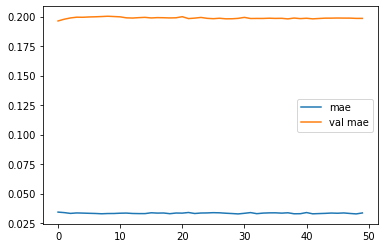

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_sapi1_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_sapi12_2 = pd.DataFrame()
data_new_sapi12_2['actual'] = x_test
data_new_sapi12_2['prediction'] = data_result2_2
data_new_sapi12_2.to_csv('sapi1_model3_sgd-type3.csv')

data_new_sapi12_2

181/181 [==============================] - 1s 4ms/step
3041.54 2.3360755 3793.6204343608233


,actual,prediction
0,129550,122846.851562
1,128900,122917.148438
2,128500,122841.492188
3,128350,122937.460938
4,127950,122934.648438
...,...,...
229,128700,126817.937500
230,130950,126794.257812
231,133850,126857.085938
232,128450,126833.726562


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 5s 35ms/step - loss: 0.1046 - mae: 0.3145 - mape: 73.8742 - val_loss: 0.1276 - val_mae: 0.2860 - val_mape: 49.2901
Epoch 2/50
44/44 [==============================] - 1s 16ms/step - loss: 0.0051 - mae: 0.0525 - mape: 12.2670 - val_loss: 0.0864 - val_mae: 0.2417 - val_mape: 47.8293
Epoch 3/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0012 - mae: 0.0229 - mape: 5.2937 - val_loss: 0.0850 - val_mae: 0.2401 - val_mape: 47.8492
Epoch 4/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0013 - mae: 0.0228 - mape: 5.2553 - val_loss: 0.0831 - val_mae: 0.2377 - val_mape: 47.8705
Epoch 5/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0013 - mae: 0.0242 - mape: 5.6022 - val_loss: 0.0857 - val_mae: 0.2409 - val_mape: 47.8474
Epoch 6/50
44/44 [==============================] - 1s 15ms/step - loss: 0.0013 - mae: 0.0231 - mape: 5.3114 - val_loss: 0.0829 - val_mae: 0.2374 - val_mape: 47.8812
Ep

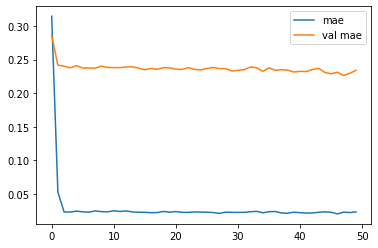

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_sapi1_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_sapi12_a = pd.DataFrame()
data_new_sapi12_a['actual'] = x_test
data_new_sapi12_a['prediction'] = data_result2_a
data_new_sapi12_a.to_csv('sapi1_model3_adam-type1.csv')

data_new_sapi12_a

131/131 [==============================] - 1s 6ms/step
2891.6858 2.222247 3587.960144706181


,actual,prediction
0,129550,123618.617188
1,128900,123626.140625
2,128500,123641.687500
3,128350,123658.070312
4,127950,123652.843750
...,...,...
229,128700,127782.640625
230,130950,127809.476562
231,133850,127905.539062
232,128450,127857.906250


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 6s 8ms/step - loss: 0.0060 - mae: 0.0479 - mape: 18.9571 - val_loss: 0.0669 - val_mae: 0.2150 - val_mape: 48.4212
Epoch 2/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0057 - mae: 0.0457 - mape: 17.5721 - val_loss: 0.0620 - val_mae: 0.2063 - val_mape: 48.4597
Epoch 3/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0056 - mae: 0.0453 - mape: 17.5357 - val_loss: 0.0651 - val_mae: 0.2121 - val_mape: 48.3024
Epoch 4/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0056 - mae: 0.0456 - mape: 17.4664 - val_loss: 0.0624 - val_mae: 0.2073 - val_mape: 48.3730
Epoch 5/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0056 - mae: 0.0449 - mape: 17.3981 - val_loss: 0.0630 - val_mae: 0.2082 - val_mape: 48.1748
Epoch 6/50
718/718 [==============================] - 5s 7ms/step - loss: 0.0053 - mae: 0.0447 - mape: 17.1168 - val_loss: 0.0638 - val_mae: 0.2099 - val_mape: 

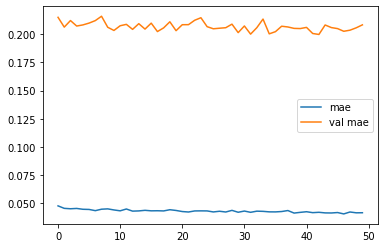

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 3ms/step
3260.4966 2.5077121 3920.9663349740713


,actual,prediction
0,129550,122184.085938
1,128900,122165.890625
2,128500,122245.609375
3,128350,122321.703125
4,127950,122349.617188
...,...,...
229,128700,127342.406250
230,130950,127200.953125
231,133850,127451.312500
232,128450,127232.367188


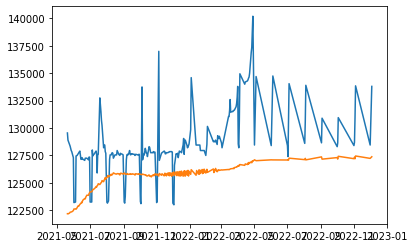

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_sapi1_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_sapi12_a1 = pd.DataFrame()
data_new_sapi12_a1['actual'] = x_test
data_new_sapi12_a1['prediction'] = data_result2_a1
data_new_sapi12_a1.to_csv('sapi1_model3_adam-type2.csv')

plt.plot(y_test, data_new_sapi12_a1.actual)
plt.plot(y_test, data_new_sapi12_a1.prediction)
data_new_sapi12_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 1s 13ms/step - loss: 0.0041 - mae: 0.0330 - mape: 8.5496 - val_loss: 0.0616 - val_mae: 0.2068 - val_mape: 48.8016
Epoch 2/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0041 - mae: 0.0321 - mape: 8.3971 - val_loss: 0.0611 - val_mae: 0.2059 - val_mape: 48.7957
Epoch 3/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0041 - mae: 0.0328 - mape: 8.5933 - val_loss: 0.0609 - val_mae: 0.2054 - val_mape: 48.7868
Epoch 4/50
84/84 [==============================] - 1s 12ms/step - loss: 0.0040 - mae: 0.0322 - mape: 8.3711 - val_loss: 0.0599 - val_mae: 0.2033 - val_mape: 48.7895
Epoch 5/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0040 - mae: 0.0323 - mape: 8.4834 - val_loss: 0.0621 - val_mae: 0.2076 - val_mape: 48.7285
Epoch 6/50
84/84 [==============================] - 1s 11ms/step - loss: 0.0040 - mae: 0.0320 - mape: 8.3731 - val_loss: 0.0623 - val_mae: 0.2078 - val_mape: 48.7202
Epoc

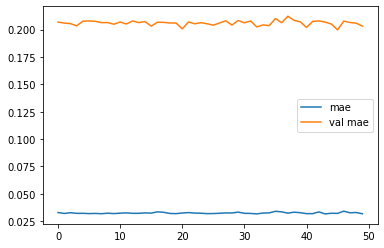

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 4ms/step
2873.45 2.2064598 3661.3821160867656


,actual,prediction
0,129550,123023.687500
1,128900,122937.242188
2,128500,123099.664062
3,128350,123074.968750
4,127950,123224.507812
...,...,...
229,128700,126826.335938
230,130950,126621.898438
231,133850,126826.257812
232,128450,126679.867188


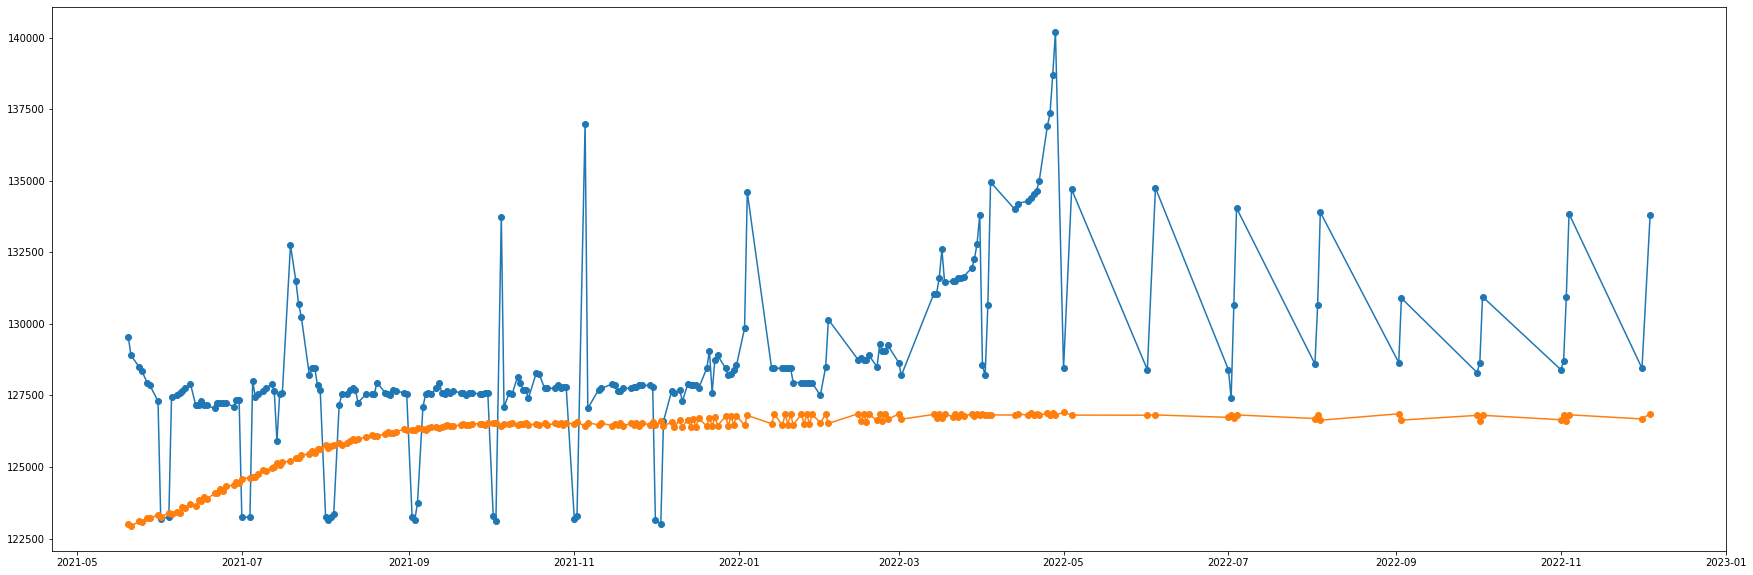

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_sapi1_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_sapi12_a2 = pd.DataFrame()
data_new_sapi12_a2['actual'] = x_test
data_new_sapi12_a2['prediction'] = data_result2_a2
data_new_sapi12_a2.to_csv('sapi1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_sapi12_a2.actual, '-o')
plt.plot(y_test,data_new_sapi12_a2.prediction, '-o')
data_new_sapi12_a2